.. _projection:

# Cookbook: read and transform Greenland data

.. versionadded:: 0.1.9

.. contents::
    :local:

### Explore the data

In [1]:
from pylab import *  # %pylab would break the doctest
%matplotlib inline
from dimarray.geo import GeoArray, get_ncfile, read_nc

Let's use a real-world example of surface velocity data from Joughin et al (2010) (see exact reference below), sub-sampled at lower resolution for testing purposes.

In [2]:
ncfile = get_ncfile('greenland_velocity.nc')
ds = read_nc(ncfile)
#ds.summary()
ds

Dataset of 6 variables
0 / y1 (113): -3400000.0 to -600000.0
1 / x1 (61): -800000.0 to 700000.0
surfvelmag: (u'y1', u'x1')
lat: (u'y1', u'x1')
lon: (u'y1', u'x1')
surfvely: (u'y1', u'x1')
surfvelx: (u'y1', u'x1')
mapping: nan

"lon" and "lat" are not the standard coordinates here. But "x1" and "y1". Let's have a closer look:

In [3]:
ds.summary()

Dataset of 6 variables

//dimensions:
0 / y1 (113): -3400000.0 to -600000.0
    units: u'meters'
    long_name: u'Cartesian y-coordinate'
    standard_name: u'projection_y_coordinate'
1 / x1 (61): -800000.0 to 700000.0
    units: u'meters'
    long_name: u'Cartesian x-coordinate'
    standard_name: u'projection_x_coordinate'

//variables:
surfvelmag: (u'y1', u'x1')
    grid_mapping: u'mapping'
    reference: u'Joughin I., Smith B.E., Howat I.M., Scambos T., Moon T., "Greenland flow variability from ice-sheet wide velocity mapping", JGlac 56(197), 2010.'
    note: u'Ian Joughin notes that "Having any papers that use the data we provided to searise cite this paper [the reference provided] gives us something we can track through ISI and report to NASA to satisfy their metrics requirements, which is a necessary evil to ensure continued production of such data sets.  So ... any publication of results based on this data should cite the above paper."'
    long_name: u'Surface Velocity Magnitu

They are obviously projection coordinates. 2-dimensional longitude and latitude coordinates are also present in the dataset.

Examining closer the attributes of 'surfvelmag' variable, a "grid_mapping" attribute is present:

In [4]:
ds['surfvelmag'].attrs # doctest: +SKIP

OrderedDict([(u'grid_mapping', u'mapping'), (u'reference', u'Joughin I., Smith B.E., Howat I.M., Scambos T., Moon T., "Greenland flow variability from ice-sheet wide velocity mapping", JGlac 56(197), 2010.'), (u'note', u'Ian Joughin notes that "Having any papers that use the data we provided to searise cite this paper [the reference provided] gives us something we can track through ISI and report to NASA to satisfy their metrics requirements, which is a necessary evil to ensure continued production of such data sets.  So ... any publication of results based on this data should cite the above paper."'), (u'long_name', u'Surface Velocity Magnitude'), (u'units', u'meters/year')])

"grid_mapping" is a string which points to another variable in the dataset, here "mapping". This is according to CF-conventions. *mapping* is a dummy variable whose attributes contain the information needed to define a coordinate reference system. 

In [5]:
grid_mapping = ds['mapping'].attrs
grid_mapping # doctest: +SKIP

OrderedDict([(u'ellipsoid', u'WGS84'), (u'latitude_of_projection_origin', 90.0), (u'straight_vertical_longitude_from_pole', -39.0), (u'standard_parallel', 71.0), (u'false_northing', 0.0), (u'grid_mapping_name', u'polar_stereographic'), (u'false_easting', 0.0)])

We can use matplotlib's contourf to get a feeling for what that all mean. Below using regular x1, y1 grid, in the projection plane.

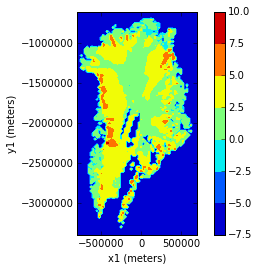

In [6]:
v = ds['surfvelmag']  # velopcity magnitude
h = log(clip(v,1e-3,inf)).contourf() # logarithm of velocity
colorbar(h)  # doctest: +SKIP
ax = gca() # get plot axis
ax.set_aspect('equal') # equal aspect ratio
ax.set_xticks([-500e3,0,500e3]) # ticks every 500 km  # doctest: +SKIP

And now plotting versus lon and lat (irregular, 2-D grid in this case):

<matplotlib.colorbar.Colorbar instance at 0x7f2e2043e680>

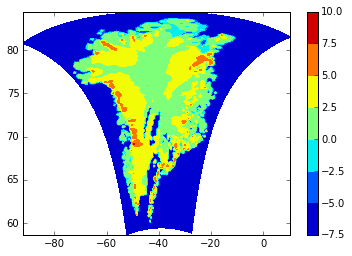

In [7]:
contourf(ds['lon'], ds['lat'], log(clip(v, 1e-3,inf))); colorbar()  # doctest: +SKIP

The polar stereographic projection (top) represent real distances in kilometers because points are projected on a plane close to the region of interest (Greenland).  In the longitude / latitude (or geodetic) (bottom) coordinate system horizontal distances are exagerated toward the pole. This is clearly visible on this figure. 

### Grid mapping to CRS class

The :func:`dimarray.geo.crs.get_crs` function returns the most adequate projection class:

In [8]:
from dimarray.geo.crs import get_crs

In [9]:
stere = get_crs(grid_mapping)
stere # doctest: +SKIP

All projection classes defined in dimarray inherit from :class:cartopy.crs.CRS. A few common transformations have a Cartopy equivalent, and are defined as subclass, where possible.

In [10]:
import cartopy.crs as ccrs
isinstance(stere, ccrs.Stereographic)

True

In [11]:
stere.transform_point(-40,71,ccrs.PlateCarree()) # project lon=-40 lat=71 (longlat coordinates) onto our coord system

(-36349.17592565123, -2082442.894090307)

So that it is also possible to directly provide a cartopy class (for user more familiar with cartopy than with CF-conventions). Note also that any such class has a :attr:`proj4_init` attribute (see cartopy's doc and source code) which is passed to PROJ.4 when performing the actual transformations:

In [12]:
stere.proj4_init

'+ellps=WGS84 +proj=stere +lat_0=90.0 +lon_0=-39.0 +x_0=0.0 +y_0=0.0 +lat_ts=71.0 +no_defs'

In some cases they are no cartopy pre-defined classes, nor dimarray. If you figure out which PROJ.4 parameters should be used, it is possible to initialize a :class:dimarray.geo.crs.Proj4 class with a PROJ.4 string, still as a subclass of cartopy's CRS. 

In [13]:
from dimarray.geo.crs import Proj4
stere2 = Proj4("+ellps=WGS84 +proj=stere +lat_0=90.0 +lon_0=-39.0 +x_0=0.0 +y_0=0.0 +lat_ts=71.0")
stere2.transform_point(-40,71,ccrs.PlateCarree())

(-36349.17592565123, -2082442.894090307)

The :func:`dimarray.geo.get_crs` function takes these various conventions and return the matching CRS instance. 

### Transform dimarrays

Let's do our first transformation with diamrray and cartopy

In [14]:
from dimarray.geo import transform

In [15]:
v = ds['surfvelmag']
vt = transform(v, from_crs=stere, to_crs=ccrs.PlateCarree())
vt

geoarray: 3208 non-null elements (3685 null)
0 / y (113): 58.6292691402 to 84.4819014732
1 / x (61): -92.1301023542 to 10.398705355
array(...)

The coordinates are quite messy, let's do something better by providing the final domain.

In [16]:
vt = transform(v, from_crs=stere, to_crs=ccrs.PlateCarree(), xt=np.arange(-92,10,0.25), yt=np.arange(59,85,0.25))
vt

geoarray: 20259 non-null elements (22173 null)
0 / y (104): 59.0 to 84.75
1 / x (408): -92.0 to 9.75
array(...)

.. note :: If xt and yt are not provided, they are determined by a forward transformation of the (meshed) original coordinates onto the new coordinate system and by building a regular grid from the transformed (irregular) coordinates. In any case, xt and yt then need to be mapped back into the original coordinate system, where the dimarray is interpolated. For that reason, it is preferable to provide xt and yt, so that only one (backward !) transformation is performed.

Double-check against earlier figures, this looks all right:

<matplotlib.colorbar.Colorbar instance at 0x7f2e20424e60>

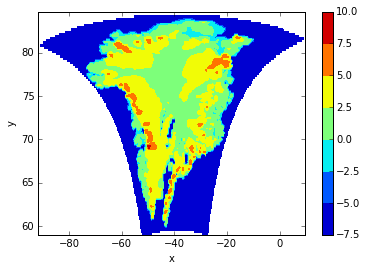

In [17]:
h = log(clip(vt,1e-3,inf)).contourf(levels=np.linspace(-7.5, 10, 8))  # doctest: +SKIP
colorbar(h) # doctest: +SKIP

So in summary transformations between coordinate reference systems are performed using cartopy's CRS subclasses. The result is always a regular dimarray.

### Transform vector fields

It is also possible to perform vector transformation (wrapper around :meth:`cartopy.crs.CRS.transform_vectors` method)

That is the original field on the projection plane.

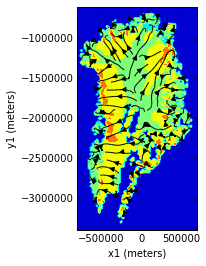

In [18]:
vx = ds['surfvelx']
vy = ds['surfvely']
log(clip(v,1e-3,inf)).contourf()   # doctest: +SKIP
streamplot(vx.x1, vx.y1, vx.values, vy.values, color='k')   # doctest: +SKIP
ax = gca()
ax.set_aspect('equal') # equal aspect ratio
ax.set_xticks([-500e3,0,500e3]) # ticks every 500 km  # doctest: +SKIP

Transforming vectors in longitude latitude coordinates does not make much sense because the angles cannot be conserved. Let's rather use a polar stereographic projection focused on the north-east side of Greenland.

In [19]:
grid_mapping = {'ellipsoid': 'WGS84',
  'grid_mapping_name': 'polar_stereographic',
  'latitude_of_projection_origin': 90.0, # +90 or -90 are accepted with this class 
  'standard_parallel': 71.0,
  'straight_vertical_longitude_from_pole': -20}

stere_ne = get_crs(grid_mapping)

.. note:: A stereographic projection would achieve similar result with parameters {'longitude_of_projection_origin':-20, 'latitude_of_projection_origin': 78.0} and further adjustment of 'false_northing'. While a stereographic projection uses a plane tangent to the Earth surface at the specified point, a polar_stereographic always uses a plane parallel to the equator, but secant to the Earth surface along the standard_parallel, where the deformation between distances on the plane and on the ellipsoid is minimal. See `cartopy issue #455 <https://github.com/SciTools/cartopy/issues/455>`_ for more discussion. 

In [20]:
from dimarray.geo import transform_vectors

/home/perrette/glacierenv/local/lib/python2.7/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


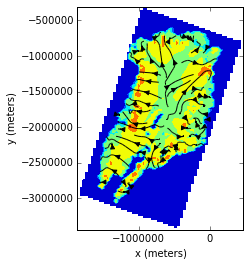

In [21]:
vt = transform(v, from_crs=stere, to_crs=stere_ne)
vxt, vyt = transform_vectors(vx,vy, from_crs=stere, to_crs=stere_ne)

log(clip(vt,1e-3,inf)).contourf()   # doctest: +SKIP
streamplot(vxt.x, vxt.y, vxt.values, vyt.values, color='k')   # doctest: +SKIP

ax = gca()
ax.set_aspect('equal') # equal aspect ratio
ax.set_xticks([-1000e3,0]) # ticks every 1000 km  # doctest: +SKIP

.. note:: The rotation is due to changing the straight longitude from pole. At x=0 north-south features lie along the y axis, whereas elsewhere they appear rotated. As far as distances are concerned, the standard parellel specification indicates the latitude at which there is no distorsion compared to the ellipsoid surface.